In [2]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [6]:

features = []
labels = []
dataset_path: str = "C:\\Users\\rclendening\\researchData\\RedVox_TrainingBinary_wYTVids"
data_dir = pathlib.Path(dataset_path)
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
droneCountDict = {  # One hot encoding for labels
    "Noise": 0,
    "Drone": 1
}

dataCount = [0, 0]
train_files=[]
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        train_files.append(os.path.join(path, name))


def split_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (MFCC)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    # middle third of data
    duration = waveData.shape[0]
    startTime = np.round(duration / 3)
    endTime = np.round(duration * 2 / 3)
    waveDataSplit= waveData[int(startTime):int(endTime)]
    features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
    dataCount[droneCountDict[labelName]] += features.shape[1]
    #label= [droneDict[labelName]] * features.shape[1]
    label= [droneCountDict[labelName]]*features.shape[1]
    return features, label

def create_dataset(train_files):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if str.split(x,"\\")[6][0] == 'y': #if youtube video mark yt as true
            yt=1
        else:
            yt=0
        test_audio, sampleRate = librosa.load(x, sr=8000)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)!=0:
            x = str(x)
            label = x.split('\\')
            label = label[5]
            newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            newFeats, newLabs = split_audio(newData, label, int(sampleRate))
            features.extend(newFeats.transpose())
            newLabs=list(zip(newLabs, np.ones(len(newLabs))*yt))
            labels.extend(newLabs)

    return features, labels

def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=1024,n_mfcc=40, sr=Fs)

    return coefs

def grabTrainingSamples(n, trainingData):
    '''
    Ensures even training set by grabbing an even amount of training samples from each class.
    @param n: limiting class count
    @param trainingData: trainingData list that includes both features and labels
    @return MFCC coefficients
    '''
    droneCount=0
    noiseCount=0
    evenTrainingData = []
    evenLabelData = []
    for i in range(len(labels)):
        lab = trainingData[i][1][0]
        if lab == 1 and droneCount < n:
            droneCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
        elif lab == 0 and noiseCount < n:
            noiseCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
    return evenTrainingData, evenLabelData

Fs = 8000
numFeat = 40 #COULD BE SOURCE OF ERROR
features, labels = create_dataset(train_files)
newSet = list(zip(features, labels))
random.seed(42)
random.shuffle(newSet)  # Ensure data is mixed together
n = np.min(dataCount)  # Ensure data is symmetric (aka even amounts of training data for all classes)
# features, labels = grabTrainingSamples(n, features, labels)
#features, labels = grabTrainingSamples(n, newSet)
labels=to_categorical(np.array(labels)[:,0],num_classes=2)
trainFeatures, testFeatures, trainTargets, testTargets = train_test_split(features, labels, test_size=0.05, random_state=42) #changed to speed up training
trainTargets=np.array(trainTargets)
trainFeatures = np.array(trainFeatures)
testTargets=np.array(testTargets)
testFeatures = np.array(testFeatures)
mean = trainFeatures.mean(axis=0)
trainFeatures -= mean
std = trainFeatures.std(axis=0)
trainFeatures /= std
trainFeatures = np.reshape(trainFeatures,
                           (len(trainFeatures), numFeat, 1))
#testFeatures = np.asarray(testFeatures)
testFeatures -= mean
testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))

C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=0
  return f(*args, **kwargs)
C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=0
  return f(*args, **kwargs)


In [4]:
from sklearn.utils import class_weight
weights=class_weight.compute_class_weight('balanced', classes=np.unique(trainTargets), y=np.argmax(trainTargets,axis=1))
weights=dict(enumerate(weights))

In [5]:
# Probabilistic range regression network
# def NLL(y, distr):  #Loss function
#    return -distr.log_prob(y)
# def normal_sp(params):  #Distribution function
#    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))  # Both mean and variance parameters are learnable
# inputs = Input(shape=(numFeat, 1))
# hidden = BatchNormalization()(inputs)
# hidden = Conv1D(64, 12, strides=2, use_bias=False, name='conv_1')(hidden)
# hidden = Conv1D(128, 12, strides=2, use_bias=False, name='conv_2')(hidden)
# #hidden = MaxPooling1D()(hidden)
# hidden = Dropout(0.25)(hidden)
# hidden = Flatten()(hidden)
# hidden = Dropout(0.1)(hidden)
# hidden = Flatten()(hidden)
# dist = Dense(5, activation='softmax', name='dense_2')(hidden)
inputs = Input(shape=(numFeat, 1))
hidden = Dropout(0.1)(inputs)
hidden = Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False,padding='same', name='conv_1')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False,padding='same', #was 32
                         name='conv_2')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Conv1D(filters=32, kernel_size=3, strides=2,padding='same', use_bias=False, #was 32
                         name='conv_3')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Flatten()(hidden) #this is where feature extraction turns to classification
hidden = Dropout(0.5)(hidden)
hidden = Dense(864, activation='relu', name='dense_1')(hidden)  # 896, 864, 928
hidden = Dropout(0.5)(hidden)
dist = Dense(len(dataCount), activation='sigmoid', name='dense_2')(hidden)
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
network = Model(inputs=inputs, outputs=dist)
network.summary()
network.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
history = network.fit(trainFeatures, trainTargets,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
# if retrain:
#     call2 = ModelCheckpoint(filepath=(dirWeights + weights_save),
#                             verbose=1, monitor='val_loss', save_best_only=True)
#     reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                  verbose=1, patience=10, mode='auto')
#     early = EarlyStopping(monitor='val_loss', min_delta=1e-4,
#                           patience=40, mode='auto')
#     history = network.fit(trainFeatures, trainTargets,
#                           epochs=1000,
#                           batch_size=32,
#                           shuffle=True,
#                           validation_split=0.2,
#                           callbacks=[reduceLR, early, call2])
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Learning Curves')
#     plt.legend(['Training Loss', 'Validation Loss'])
#     plt.ylabel('Binary Crossentropy')
#     plt.xlabel('Epoch Number')
#     plt.show()
#     network.load_weights(dirWeights + weights_load, by_name=True)
# else:
#     network.load_weights(dirWeights + weights_load, by_name=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 dropout (Dropout)           (None, 40, 1)             0         
                                                                 
 conv_1 (Conv1D)             (None, 20, 32)            96        
                                                                 
 batch_normalization (BatchN  (None, 20, 32)           128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 10, 32)            3072      
                                                             

ValueError: in user code:

    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 2)).


In [33]:
# Save network for future use
saved_network=network.to_json()
with open("model_woverlap_padding_v2.json", "w") as json_file:
    json_file.write(saved_network)
network.save_weights('model_woverlap_padding.V2')

In [34]:
from sklearn import metrics
#print(testFeatures)
network.evaluate(x=testFeatures,y=testTargets)
y_pred = np.argmax(network.predict(testFeatures), axis=1)
y_true = testTargets



ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'})

[0.         0.10748703 0.11060044 ... 1.         1.         1.        ]
[0.         0.         0.         ... 0.94512878 0.94587533 1.        ]


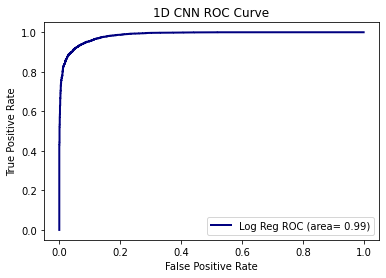

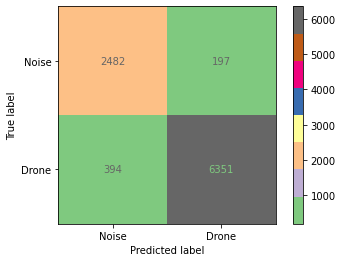

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
y_true_int = np.argmax(y_true, axis=1)
fpr,tpr,thresh= roc_curve(y_true=y_true_int, y_score=network.predict(testFeatures)[:,1])
aucVal=auc(fpr,tpr)
print(tpr)
print(fpr)
plt.plot(fpr,tpr,color='navy',label="Log Reg ROC (area= %0.2f)" %aucVal, lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("1D CNN ROC Curve")
plt.legend()
#plt.savefig('.\ROCCurve.pdf')
cm= confusion_matrix(y_true_int,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Noise','Drone'])
disp.plot(cmap='Accent')
plt.show()
#plt.savefig('.\confusionMatrixCNN.pdf')

SVM code so it has same dataset split

In [231]:
from sklearn import svm
train_classes = np.argmax(trainTargets, axis=1)
model = svm.SVC(kernel='rbf', C=100, gamma=0.01)
model.fit(trainFeatures.squeeze(),train_classes)

SVC(C=100, gamma=0.01)

In [233]:
svm_pred= model.predict(testFeatures)
svm_score=model.score(testFeatures,y_true_int)
print(svm_score)
cm= confusion_matrix(y_true_int,svm_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Noise','Drone'])
disp.plot(cmap='Accent')

ValueError: Found input variables with inconsistent numbers of samples: [14086, 6612]

This function implements majority voting scheme. It assumes all cell phones record an equal amount of data during a test, and assumes the class with the most votes is the correct class.

In [45]:
json_file=open(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\model_woverlap_padding_v1.json", 'r')
loaded_network_json = json_file.read()
json_file.close()
loaded_network = tf.keras.models.model_from_json(loaded_network_json)
loaded_network.load_weights(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\model_woverlap_padding.V1").expect_partial()
loaded_network.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
loaded_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 dropout (Dropout)           (None, 40, 1)             0         
                                                                 
 conv_1 (Conv1D)             (None, 20, 32)            96        
                                                                 
 batch_normalization (BatchN  (None, 20, 32)           128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 10, 32)            3072      
                                                             

In [21]:
NOISE=0
DRONE=1
usable_phones=["Phone_1-3.wav",
"Phone_2-4.wav",
"Phone_6-2.wav", #gps n/a
"Phone_6-3.wav",
"Phone_6-4.wav", #gps n/a
"Phone_6-5.wav",
"Phone_7-2.wav",
"Phone_9.wav"
]
json_file=open(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\model_woverlap.json", 'r')
loaded_network_json = json_file.read()
json_file.close()
loaded_network = tf.keras.models.model_from_json(loaded_network_json)
loaded_network.load_weights(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\model_woverlap.V1").expect_partial()
loaded_network.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)


def split_test_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    duration = waveData.shape[0]
    waveData=waveData.numpy().squeeze()
    features=MFCCCalc(waveData,Fs=8000)
    label= [droneDict[labelName]] * features.shape[1]
    return features, label

def create_test_dataset(test_files, testTime):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    features = []
    featuresLL=[]
    labels = []
    numPhones=0
    for x in test_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if len(test_audio) >= (testTime)*sampleRate and min(np.asarray(test_audio)) != 0: #ensure data actually has sound and recorded correctly
        #if x.split('\\')[7] in usable_phones:
            numPhones+=1
            x = str(x)
            #print(x.split('\\')[7])
            label = x.split('\\')[6]
            #label = label[6]
            #test_audio = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
            test_audio = test_audio[0: (testTime-1)*sampleRate]  # trim to nearest second
            #test_audio = test_audio[round(testTime/3)*sampleRate: round(testTime)*sampleRate]  # trim to nearest second
            newFeats, newLabs = split_test_audio(test_audio, "Drone", int(sampleRate))
            featuresLL.append(newFeats.transpose())
            features.extend(newFeats.transpose())
            labels.extend(newLabs)

    return features, labels, numPhones, featuresLL

def majorityVote(testFeats, testTruth, numPhones, y_pred):
    samplesPerPhone=len(testFeats)/numPhones
    i=0
    correct=0
    correctOverTime=[]
    classPrediction=[]
    droneTot,noiseTot=0,0
    for i in range(int(samplesPerPhone-1)):
        drone, noise=0,0
        for phone in range(numPhones):
            val=i+phone*int(samplesPerPhone)
            if y_pred[val].tolist()==[1,0,0,0,0]:
                drone+=1
                droneTot+=1
            elif y_pred[val].tolist()==[0,1,0,0,0]:
                noise+=1
                noiseTot+=1
        valueList=[drone, noise]
        #if np.argmax(valueList) == testTruth:
        if valueList[testTruth]/numPhones > 0.50:
            correct+=1
            prediction = testTruth
        else:
            prediction = 1
        correctOverTime.append(valueList[testTruth])
        classPrediction.append(prediction)
    totCounts=[droneTot,noiseTot]
    return correct, correctOverTime, classPrediction, totCounts
def maxValues(features):
    maxVals=[]
    for x in features:
        #maxVals.append(abs(x).max())
        #print("val:",(x[0][0]))
        maxVals.append(x[0][0]) #average power of signal
    return maxVals

def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr
def majorityVoteNew(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        #pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        pred= loaded_network.predict(x)[:,1] > 0.68
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    prevState=4
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >0.52: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        prevState, prediction=threeBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)

    return predictedList, y_prediction

def threeBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>3:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>7:
        prevPredictState=7
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def twoBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>1:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>3:
        prevPredictState=3
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def fourBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>7:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>15:
        prevPredictState=15
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction
testTime=90
dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\A3R6P4" #TODO
Testdata_dir = pathlib.Path(dataset_path)
phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
# oldTF= testFeatures
# oldTT =testTargets
testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
predictedList, y_prediction = majorityVoteNew(featuresLL)
print(numPhones)
correcto=0

for y in y_prediction:
    correcto=1
    for x in range(0,348):
        if y[x] == 0:
            correcto+=1
    print("Single Phone",correcto/349)
correcto=0
for x in range(0,348):
    if predictedList[x] == 0:
        correcto+=1
print("Accuracy for drone present:", correcto/349)
plt.plot(range(len(predictedList)),predictedList)
plt.figure()
#plt.plot(classPrediction)






KeyboardInterrupt: 

Average Value: 0.7752571082879613
Accuracy for drone present: 0.8419540229885057
Novel method outperforms by: 8.603199375731556 %


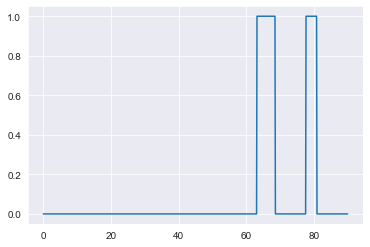

<Figure size 432x288 with 0 Axes>

In [17]:
correcto=0
sumVal=0
phone=0
start=0
stop=len(predictedList)
#y_actual=[1]*50+[0]*150+[1]*1000
#y_actual=[1]*250+[0]*500+[1]*800
#y_actual=[1]*975+[0]*500+[1]*800
y_actual=np.zeros(len(predictedList))
y_actual[int(np.round(len(predictedList)*58/testTime)):int(np.round(len(predictedList)*81/testTime))]=1
for y in y_prediction:
    phone+=1
    correcto=0
    for x in range(start,stop):
        if y[x] == y_actual[x]:
            correcto+=1
    #print("Single Phone",phone)
    #print(correcto/(stop-start))
    sumVal+= correcto/(stop-start)
print("Average Value:", sumVal/len(y_prediction))
correcto=0
for x in range(start,stop):
    if predictedList[x] == y_actual[x]:
        correcto+=1
print("Accuracy for drone present:", correcto/(stop-start))
plt.plot(np.arange(0,testTime,testTime/len(predictedList)),predictedList)
#plt.plot(predictedList)
plt.figure()
print("Novel method outperforms by:", (100*((correcto/(stop-start))-sumVal/len(y_prediction))/abs(sumVal/len(y_prediction))), "%")
#plt.plot(classPrediction)

# Model Tuning

In [20]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score
tuning_runs=["A3R3P1","A3R5P1","A3R4P2","A3R6P2"]
start=0
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\test_data\drone_test_truth_data_within_233m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
testTime=90
def majorityVoteTuning(testFeats, fusionThresh,networkThresh):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        #pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        pred= loaded_network.predict(x)[:,1] > networkThresh
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    prevState=4
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >fusionThresh: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        prevState, prediction=threeBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)

    return predictedList, y_prediction
def tuning(fusion_thresholds,net_thresholds):
    best_fusion=0.0
    best_network=0.0
    best_score=0.0
    for fus_thresh in fusion_thresholds:
        for net_thresh in net_thresholds:
            novelAve=[]
            for x in range(13):
                truthScenario = truthData.iloc[x]
                if truthScenario[0] in tuning_runs:
                    #read scenario and truth data
                    name=truthScenario[0]
                    startDetect= truthScenario[1]
                    endDetect=truthScenario[2]
                    dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
                    Testdata_dir = pathlib.Path(dataset_path)
                    phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
                    # convert to MFCC space
                    testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
                    # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
                    fusion_prediction, y_prediction = majorityVoteTuning(featuresLL,fus_thresh,net_thresh)
                    #
                    num_frames=len(fusion_prediction) #length of one scenario in frames
                    y_actual=np.zeros(num_frames)
                    y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
                    # Report balanced accuracy scores
                    tot_indiv_score=0
                    for y in y_prediction:
                        indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
                        #print(indiv_score)
                        tot_indiv_score+= indiv_score
                    tot_indiv_score=tot_indiv_score/len(y_prediction)

                    #################### Score Reporting #################
                    fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
                    novelAve.append(fusion_score)
                    print(np.average(novelAve))
                if np.average(novelAve) > best_score:
                    best_fusion=fus_thresh
                    best_network=net_thresh
                    best_score=np.average(novelAve)
    print("Best fusion threshold:",best_fusion)
    print("Best network threshold:",best_network)
fusion_vals=[0.52,0.55,0.57,0.6,0.65,0.70]
thresh_vals=[0.55,0.6,0.65,0.70,0.68,0.72]
tuning(fusion_vals,thresh_vals)

22/22 [==============================] - 0s 1ms/step
0.9425287356321839
22/22 [==============================] - 0s 1ms/step
0.9281609195402298
22/22 [==============================] - 0s 1ms/step
0.9185823754789272
22/22 [==============================] - 0s 1ms/step
0.8987068965517241
22/22 [==============================] - 0s 2ms/step
0.9425287356321839
22/22 [==============================] - 0s 1ms/step
0.9295977011494252
22/22 [==============================] - 0s 1ms/step
0.9200191570881225
22/22 [==============================] - 0s 1ms/step
0.9048132183908046
22/22 [==============================] - 0s 2ms/step
0.9439655172413793
22/22 [==============================] - 0s 1ms/step
0.9317528735632183
22/22 [==============================] - 0s 1ms/step
0.9243295019157087
22/22 [==============================] - 0s 1ms/step
0.910919540229885
22/22 [==============================] - 0s 2ms/step
0.9454022988505747
22/22 [==============================] - 0s 1ms/step
0.9267241379

# Performance evaluation

In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score
start=0
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\test_data\drone_test_truth_data_within_233m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
testTime=90
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    if truthScenario[0] not in tuning_runs:
        name=truthScenario[0]
        startDetect= truthScenario[1]
        endDetect=truthScenario[2]
        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
        Testdata_dir = pathlib.Path(dataset_path)
        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
        # convert to MFCC space
        testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
        # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
        fusion_prediction, y_prediction = majorityVoteNew(featuresLL)
        #
        num_frames=len(fusion_prediction) #length of one scenario in frames
        y_actual=np.zeros(num_frames)
        y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
        # Report balanced accuracy scores
        tot_indiv_score=0
        for y in y_prediction:
            indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
            #print(indiv_score)
            tot_indiv_score+= indiv_score
        tot_indiv_score=tot_indiv_score/len(y_prediction)

        #################### Score Reporting #################
        print(name)
        print("Number of used phones:",len(y_prediction))
        print("Average Value:", tot_indiv_score)
        sumAve.append(tot_indiv_score)
        fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
        novelAve.append(fusion_score)
        print("Accuracy for drone present:", fusion_score)
        performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
        outPerform.append(performanceGain)
        recall.append(recall_score(y_actual,fusion_prediction))
        precision.append(precision_score(y_actual,fusion_prediction))
        print("Recall score:", recall_score(y_actual,fusion_prediction))
        print("Precision score:", precision_score(y_actual,fusion_prediction))
        print("Novel method outperforms by:", performanceGain, "%")
        print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

22/22 [==============================] - 0s 2ms/step
A3R3P2
Number of used phones: 19
Average Value: 0.7869026013309135
Accuracy for drone present: 0.9554597701149425
Recall score: 0.9067357512953368
Precision score: 0.9308510638297872
Novel method outperforms by: 21.420334422448587 %
_________________________
22/22 [==============================] - 0s 2ms/step
A3R3P3
Number of used phones: 20
Average Value: 0.7916666666666667
Accuracy for drone present: 0.9540229885057471
Recall score: 0.8704663212435233
Precision score: 0.96
Novel method outperforms by: 20.508166969146988 %
_________________________
22/22 [==============================] - 0s 1ms/step
A3R4P1
Number of used phones: 24
Average Value: 0.6431992337164751
Accuracy for drone present: 0.8778735632183908
Recall score: 0.9067357512953368
Precision score: 0.7231404958677686
Novel method outperforms by: 36.485480268056584 %
_________________________
22/22 [==============================] - 0s 1ms/step
A3R4P3
Number of used pho

# Just majority vote Scoring

In [30]:
def majorityVoteAlone(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        #pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        pred= loaded_network.predict(x)[:,1] > 0.6
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    numPhones=len(y_prediction)
    predictedList=[]
    prevState=7
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1

        #if predictedDrone/maxVote >0.57: #adjusted from 0.6 to 0.7
        if predictedDrone/numPhones >0.5:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)

    return predictedList, y_prediction
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\test_data\drone_test_truth_data_within_233m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    name=truthScenario[0]
    startDetect= truthScenario[1]
    endDetect=truthScenario[2]
    dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
    Testdata_dir = pathlib.Path(dataset_path)
    phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
    # convert to MFCC space
    testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
    # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
    fusion_prediction, y_prediction = majorityVoteAlone(featuresLL)
    #
    num_frames=len(fusion_prediction) #length of one scenario in frames
    y_actual=np.zeros(num_frames)
    y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
    # Report balanced accuracy scores
    tot_indiv_score=0
    for y in y_prediction:
        indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
        #print(indiv_score)
        tot_indiv_score+= indiv_score
    tot_indiv_score=tot_indiv_score/len(y_prediction)

    #################### Score Reporting #################
    print(name)
    print("Number of used phones:",len(y_prediction))
    print("Average Value:", tot_indiv_score)
    sumAve.append(tot_indiv_score)
    fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
    novelAve.append(fusion_score)
    print("Accuracy for drone present:", fusion_score)
    performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
    outPerform.append(performanceGain)
    recall.append(recall_score(y_actual,fusion_prediction))
    precision.append(precision_score(y_actual,fusion_prediction))
    print("Recall score:", recall_score(y_actual,fusion_prediction))
    print("Novel method outperforms by:", performanceGain, "%")
    print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

22/22 [==============================] - 0s 739us/step
A3R3P1
Number of used phones: 21
Average Value: 0.7577996715927752
Accuracy for drone present: 0.8089080459770115
Recall score: 0.31088082901554404
Novel method outperforms by: 6.744312026002149 %
_________________________
22/22 [==============================] - 0s 1ms/step
A3R3P2
Number of used phones: 19
Average Value: 0.7678463399879006
Accuracy for drone present: 0.8505747126436781
Recall score: 0.5284974093264249
Novel method outperforms by: 10.774079180618491 %
_________________________
22/22 [==============================] - 0s 1ms/step
A3R3P3
Number of used phones: 20
Average Value: 0.7755028735632185
Accuracy for drone present: 0.8419540229885057
Recall score: 0.43523316062176165
Novel method outperforms by: 8.56878184344603 %
_________________________
22/22 [==============================] - 0s 2ms/step
A3R4P1
Number of used phones: 24
Average Value: 0.62290469348659
Accuracy for drone present: 0.860632183908046
Recall 

C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Majority Vote with Weighting

In [31]:

def majorityVoteWithWeighting(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        #pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        pred= loaded_network.predict(x)[:,1] > 0.6
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    prevState=5
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >0.6: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        predictedList.append(predictedVal)

    return predictedList, y_prediction
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\test_data\drone_test_truth_data_within_233m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    name=truthScenario[0]
    startDetect= truthScenario[1]
    endDetect=truthScenario[2]
    dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
    Testdata_dir = pathlib.Path(dataset_path)
    phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
    # convert to MFCC space
    testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
    # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
    fusion_prediction, y_prediction = majorityVoteWithWeighting(featuresLL)
    #
    num_frames=len(fusion_prediction) #length of one scenario in frames
    y_actual=np.zeros(num_frames)
    y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
    # Report balanced accuracy scores
    tot_indiv_score=0
    for y in y_prediction:
        indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
        #print(indiv_score)
        tot_indiv_score+= indiv_score
    tot_indiv_score=tot_indiv_score/len(y_prediction)

    #################### Score Reporting #################
    print(name)
    print("Number of used phones:",len(y_prediction))
    print("Average Value:", tot_indiv_score)
    sumAve.append(tot_indiv_score)
    fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
    novelAve.append(fusion_score)
    print("Accuracy for drone present:", fusion_score)
    performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
    outPerform.append(performanceGain)
    recall.append(recall_score(y_actual,fusion_prediction))
    precision.append(precision_score(y_actual,fusion_prediction))
    print("Recall score:", recall_score(y_actual,fusion_prediction))
    print("Novel method outperforms by:", performanceGain, "%")
    print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

22/22 [==============================] - 0s 744us/step
A3R3P1
Number of used phones: 21
Average Value: 0.7577996715927752
Accuracy for drone present: 0.9022988505747126
Recall score: 0.6580310880829016
Novel method outperforms by: 19.06825568797397 %
_________________________
22/22 [==============================] - 0s 1ms/step
A3R3P2
Number of used phones: 19
Average Value: 0.7678463399879006
Accuracy for drone present: 0.9339080459770115
Recall score: 0.8341968911917098
Novel method outperforms by: 21.6269450462872 %
_________________________
22/22 [==============================] - 0s 1ms/step
A3R3P3
Number of used phones: 20
Average Value: 0.7755028735632185
Accuracy for drone present: 0.9396551724137931
Recall score: 0.8186528497409327
Novel method outperforms by: 21.16720704029643 %
_________________________
22/22 [==============================] - 0s 745us/step
A3R4P1
Number of used phones: 24
Average Value: 0.62290469348659
Accuracy for drone present: 0.8333333333333334
Recall 